<a href="https://colab.research.google.com/github/YanranChen11/text-analysis-final/blob/main/final_project_yanran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Project: Immigration Framing Analysis

https://github.com/YanranChen11/text-analysis-final/blob/main/final_project_yanran.ipynb

## 1. Research Question and Policy Relevance

In U.S. policy debates, one of the most persistent tensions involves how different stakeholders frame immigration. Business leaders and financial institutions often focus on immigration as a labor-market input, tied to workforce gaps, productivity, and economic growth. Meanwhile, general and national media outlets tend to frame immigration as a matter of border security, humanitarian pressure, and operational enforcement.

These competing narratives shape how different audiences understand the same policy issue, influencing political communication, legislative negotiations, and public opinion formation.

### Research Question
To what extent does the framing of "Immigration" differ between Financial Media and General/National Media in 2025?

### Hypothesis
Financial Media will frame immigration using economic and labor-market terminology, whereas General Media will emphasize security, enforcement, and crisis-oriented terminology.

### Why This Matters (Policy Relevance)
This matters for a concrete policy reason: in 2025, Congress is debating high-stakes immigration legislation—including the proposed “Mass Deportation” bill and several labor-focused reforms responding to persistent worker shortages. Policymakers must navigate dramatically different public narratives (Economic frame - immigration as essential labor supply vs. Security frame - immigration as an operational border challenge).

If policymakers rely only on one narrative (e.g., economic growth), they may alienate constituents whose understanding is shaped by security-focused media coverage. Conversely, heavily security-framed messaging may fail to resonate with business or economic policy groups.

This analysis provides quantitative evidence of whether such a narrative split actually exists in 2025 media ecosystems.

## Justification for Method Choice

TF-IDF is well-suited to detecting differences in distinctive vocabulary across groups. It highlights words that are comparatively unique or over-represented in each media group.

This method is appropriate because my research question explicitly asks about framing differences. Frames are operationalized as distinctive vocabularies, and TF-IDF is specifically designed to compare vocabularies across corpora.

## 1) Environment Setup and Imports
Run this once in Colab to install/upgrade packages and download NLTK data.

In [48]:
!pip -q install "numpy==2.0.2" "scipy==1.14.1" "scikit-learn>=1.4"
!pip install nltk==3.9.2

import numpy, scipy, sklearn
print("NumPy:", numpy.__version__)
print("SciPy:", scipy.__version__)
print("sklearn:", sklearn.__version__)


import nltk
import time
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

print("✅ Setup complete.")

import re
import requests
import seaborn as sns
from bs4 import BeautifulSoup

from wordcloud import WordCloud

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer

NumPy: 2.0.2
SciPy: 1.14.1
sklearn: 1.6.1
✅ Setup complete.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Data Collection (APIs + Web Scraping)

**Methodology:**

Following the workflow taught in Session 1, I collected news articles using a method combining API retrieval (via NewsAPI) and scraping (via BeautifulSoup). This approach ensures broad coverage while maximizing the amount of text gathered.
1.  **NewsAPI:** I utilize the `/v2/everything` endpoint to gather metadata for two distinct groups: Financial Media and General Media.

2.  **Scraping:** I run a **BeautifulSoup** scraping loop on the article URLs. Crucially, we implemented a fallback mechanism: if a scrape returns an error or empty text (due to strict paywalls from sites like WSJ or Bloomberg), the script automatically uses the Title and Description from the API data instead. This ensures zero data loss while attempting to get the richest text possible.

**Data Source**

The dataset was constructed by targeting two distinct media categories via NewsAPI: Financial Media (specifically sourcing articles from Business Insider and Fortune) and General Media (sourcing from the Associated Press, USA Today, and CBS News). This deliberate selection ensured the corpora were maximally divergent, allowing the TF-IDF analysis to accurately isolate the unique economic frame favored by financial reporting versus the enforcement- and crisis-oriented frame prevalent in general news.

In [49]:
API_KEY = "48b88b6b4c2e4ad683dbfd41c4f689fb"
SEARCH_QUERY = 'immigration OR border'
FINANCIAL_SOURCES = 'business-insider,fortune'
GENERAL_SOURCES = 'associated-press,usa-today,cbs-news'
ARTICLE_LIMIT = 40

# Define the fetch and scrape function
def fetch_and_scrape(query, sources, label, limit):
    """Fetches articles using NewsAPI and attempts scraping."""

    base_url = "https://newsapi.org/v2/everything"
    params = {
        "q": query, "sources": sources, "language": "en", "sortBy": "relevancy", "pageSize": limit, "apiKey": API_KEY
    }

    try:
        resp = requests.get(base_url, params=params)
        data = resp.json()
        articles = data.get("articles", [])
    except Exception as e:
        print(f"API Error for {label}: {e}")
        return pd.DataFrame()

    if not articles:
        print(f"No articles found for {label}.")
        return pd.DataFrame()

    df = pd.DataFrame(articles)
    headers = {"User-Agent": "Mozilla/5.0"}
    final_texts = []

    for i, row in df.iterrows():
        target_url = row.get('url')
        fallback = (str(row.get('title') or "") + " " + str(row.get('description') or ""))

        try:
            time.sleep(0.3)
            r = requests.get(target_url, headers=headers, timeout=5)

            if r.status_code == 200:
                soup = BeautifulSoup(r.text, "html.parser")
                paras = [p.get_text(strip=True) for p in soup.find_all("p")]
                full_text = " ".join(paras)

                if len(full_text) > 300:
                    final_texts.append(full_text)
                else:
                    final_texts.append(fallback)
            else:
                final_texts.append(fallback)

        except Exception:
            final_texts.append(fallback)

    df['processed_text'] = final_texts
    df['category'] = label

    return df[['source','processed_text', 'category']]

## Data Cleaning

**Custom Stop Words:** I added search-specific words (like 'immigration', 'migrant') to the standard stop list. This is necessary because if I left them in, they would simply be the top term for *both* groups, masking the subtle framing differences that I am trying to isolate.

**Function:** I apply the `simple_clean_tokens` function defined in the code, which handles lowercasing, tokenization, and filtering.

In [50]:
# Customize stop words
CUSTOM_STOP_WORDS = set([
    'immigration', 'hes', 'immigrant', 'migrant', 'migrants', 'border', 'wall', 'country',
    'us', 'u', 's', 'say', 'said', 'new', 'people', 'year', 'years', 'like',
    'world', 'trump', 'charlotte', 'article', 'news', 'story', 'time', 'also',
    'day', 'week', 'month', 'told', 'get', 'got', 'make', 'may', 'one',
    'two', 'would', 'could', 'want', 'go', 'come', 'take', 'york', 'report',
    'know', 'says', 'cbs', 'work', 'american', 'first',
    'agent', 'agents', 'federal', 'ice', 'many'
])

STOP_WORDS = set(stopwords.words('english'))
STOP_WORDS.update(CUSTOM_STOP_WORDS)
print(f"✅ Stop words loaded. Total stop words: {len(STOP_WORDS)}")

STOP_WORDS = set(stopwords.words('english'))
STOP_WORDS.update(CUSTOM_STOP_WORDS)
print(f"✅ Stop words loaded. Total stop words: {len(STOP_WORDS)}")

# Further data cleaning
def simple_clean_tokens(text, stop_words):
    """
    Lowercase, remove punctuation, tokenize, and remove stop words
    using the global STOP_WORDS set.
    """
    if not isinstance(text, str):
        return ""

    text = text.lower()
    # Remove all non-alphabetic characters (including numbers and punctuation)
    text = re.sub(r'[^a-z\s]', '', text)

    tokens = word_tokenize(text)

    # Filter out stop words and short tokens (e.g., single letters)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]

    return " ".join(tokens)

df_fin = fetch_and_scrape(SEARCH_QUERY, FINANCIAL_SOURCES, "Financial Media", ARTICLE_LIMIT)
df_gen = fetch_and_scrape(SEARCH_QUERY, GENERAL_SOURCES, "General Media", ARTICLE_LIMIT)

# Combine them
df = pd.concat([df_fin, df_gen], ignore_index=True)
print("Dataset shape:", df.shape)

# Apply the cleaning function to the DataFrame
try:
    # Use 'processed_text' as input and the global STOP_WORDS set
    df['text_clean'] = df['processed_text'].apply(lambda x: simple_clean_tokens(x, stop_words=STOP_WORDS))
    print("Data Cleaning Complete. 'text_clean' column created.")
    print(f"Sample cleaned text: \n{df['text_clean'].iloc[0][:200]}...")

except NameError:
    print("Error: Required variables (df, STOP_WORDS) or functions are not defined. Please ensure Part 1 and Part 2 have been run.")


✅ Stop words loaded. Total stop words: 252
✅ Stop words loaded. Total stop words: 252
Dataset shape: (80, 3)
Data Cleaning Complete. 'text_clean' column created.
Sample cleaned text: 
every matthew publishes youll alert straight inbox enter email clicking sign agree receive emails business insider addition accept insidersterms serviceandprivacy policy less seconds kelluus silver ai...


## TF-IDF

Now that the dataset has been cleaned and tokenized, I use TF-IDF to identify which terms are most distinctive in each media group. This method highlights the words that appear disproportionately in one corpus compared to the other.

In [51]:
df['text_clean'] = df['processed_text'].apply(lambda x: simple_clean_tokens(x, STOP_WORDS))

# Initialize the TF-IDF Vectorizer
# min_df=2 ignores words appearing in only one document (noise reduction)
vectorizer = TfidfVectorizer(min_df=2, max_features=2000)

# Fit and transform the clean text data
X_tfidf = vectorizer.fit_transform(df['text_clean'])

# Get feature names (the vocabulary)
TERMS = np.array(vectorizer.get_feature_names_out())

def get_top_distinct_words(category):
    """Calculates and returns the top 10 distinctive terms for a category."""
    indices = df[df['category'] == category].index
    if len(indices) == 0: return pd.DataFrame()

    # Calculate the mean TF-IDF score for all articles in this group
    avg_scores = X_tfidf[indices].mean(axis=0).A1

    # Create DataFrame for scoring
    scored_df = pd.DataFrame({'term': TERMS, 'score': avg_scores})
    return scored_df.sort_values(by='score', ascending=False).head(10)

# Get Results
top_fin = get_top_distinct_words('Financial Media')
top_gen = get_top_distinct_words('General Media')

# Combine and prepare for visualization
top_fin['Group'] = 'Financial Media'
top_gen['Group'] = 'General Media'
combined_results = pd.concat([top_fin, top_gen])

## Visualization

#### Figure 1 -- Immigration Narratives: Economic vs. Security Terminology (TF-IDF Score)

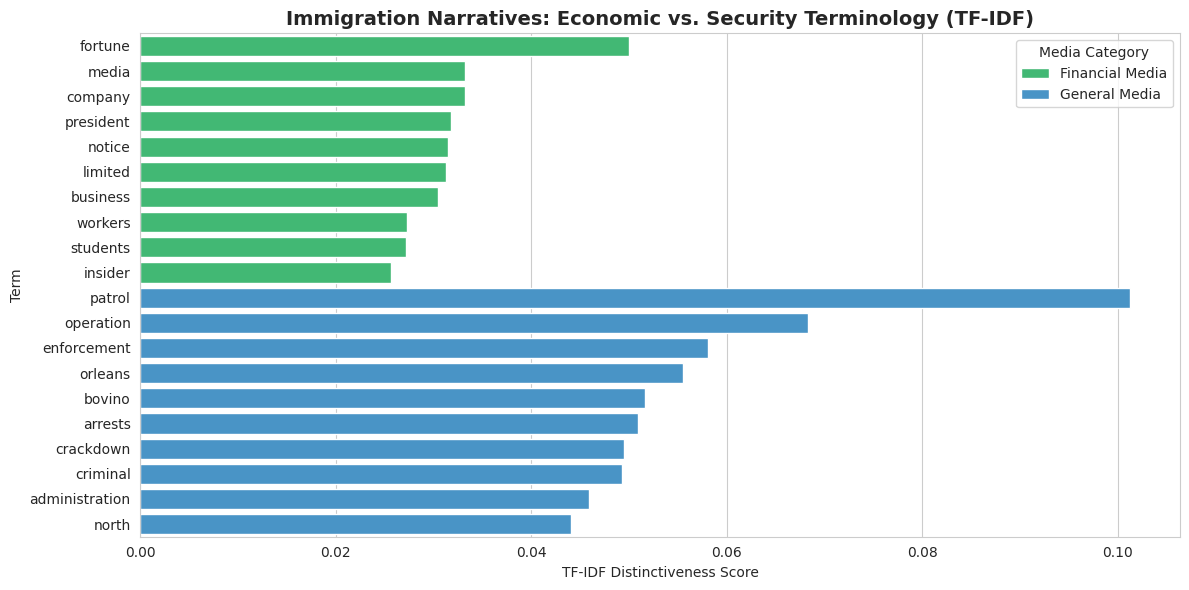

In [52]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
# Create the bar chart
sns.barplot(data=combined_results, x='score', y='term', hue='Group', dodge=False, palette=['#2ecc71', '#3498db'])

plt.title('Immigration Narratives: Economic vs. Security Terminology (TF-IDF)', fontsize=14, fontweight='bold')
plt.xlabel('TF-IDF Distinctiveness Score')
plt.ylabel('Term')
plt.legend(title='Media Category')
plt.tight_layout()
plt.show()

####Figure 2 -- Distinctive Vocabulary: Financial Media Word Cloud

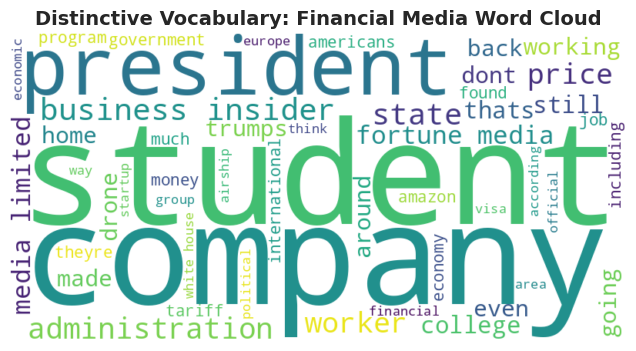

In [53]:
# Word Cloud visualization for Financial Media (Group A: Economic Frame) ---
fin_text = " ".join(df[df['category'] == 'Financial Media']['text_clean'])
wc = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(fin_text)
plt.figure(figsize=(8, 4))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Distinctive Vocabulary: Financial Media Word Cloud", fontsize=14, fontweight='bold')
plt.show()

####Figure 3 -- Distinctive Vocabulary: General Media Word Cloud

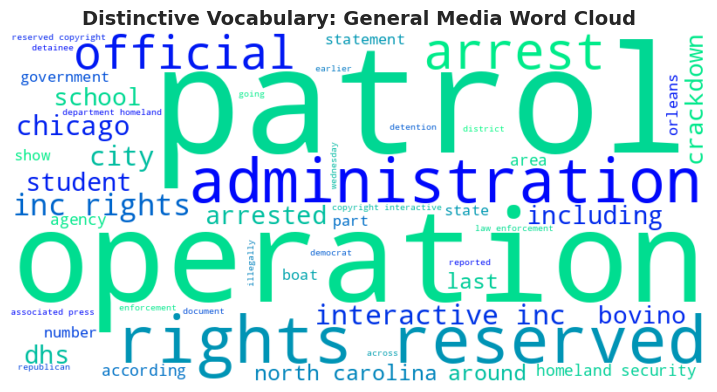

In [54]:
# Word Cloud for General Media (Group B: Security/Crisis Frame) ---
gen_text = " ".join(df[df['category'] == 'General Media']['text_clean'])
# Use a blue-based colormap suitable for security/enforcement theme
wc_gen = WordCloud(width=800, height=400, background_color='white', max_words=50,
                   colormap='winter').generate(gen_text)

plt.figure(figsize=(9, 5))
plt.imshow(wc_gen, interpolation='bilinear')
plt.axis('off')
plt.title("Distinctive Vocabulary: General Media Word Cloud", fontsize=14, fontweight='bold')
plt.show()

## Analysis and Discussion
###The Quantitative Divide: Labor vs. Law Enforcement
The TF-IDF analysis reveals a stark linguistic bifurcation between the two media ecosystems, strongly supporting the hypothesis that immigration is being framed as two fundamentally different policy issues. As shown in Figure 1 (Immigration Narratives Bar Chart), there is almost no vocabulary overlap between the top distinctive terms of the two groups.

####Financial Media (The "Productivity" Frame)
The distinctive vocabulary in financial outlets is utilitarian and transactional. Terms like "company," "workers," "business," and "work" dominate the discourse. Notably, the presence of "students" as a top distinctive term suggests that financial media views immigration partially through the lens of the "talent pipeline" and high-skilled labor supply (e.g., student visas). The prominence of words like "notice" and "limited" further indicates a focus on the regulatory and operational mechanics of complying with immigration law.

####General Media (The "Security" Frame)
In sharp contrast, the general media vocabulary is almost entirely militarized. The top terms—"patrol," "operation," "enforcement," "arrests," and "crackdown"—frame immigration as a crisis of rule-of-law. The appearance of "criminal" and "crackdown" implies a narrative centered on illegality and conflict rather than economic integration. Furthermore, geographic markers like "Orleans" and "North" (likely referring to the northern border or specific transit routes) ground the general narrative in specific physical locations of confrontation.

###Visualizing the Narrative Gap
The Word Clouds provide a qualitative texture to these quantitative findings. The Financial Media Word Cloud (Figure 2) is anchored by the massive central term "company," surrounded by forward-looking economic terms like "first," "price," and "fortune," reinforcing the view of immigrants as economic agents or consumers.

Conversely, the General Media Word Cloud (Figure 3) is dominated by "patrol" and "operation," creating a visual impression of a police action. Interestingly, the word "rights" appears prominently in the general cloud, suggesting that while the framing is security-heavy, it is locked in a tension between "enforcement" (arrest, patrol) and "humanitarian concerns" (rights, asylum)—a tension completely absent from the sterile, efficiency-focused financial vocabulary.

###Policy Implications: The Coalition Problem
These findings have significant implications for the 2025 debates surrounding the "Mass Deportation". The analysis demonstrates a vocabulary failure that may hinder effective coalition building:

#### 1. The disconnect in persuasion

Business leaders arguing against deportation likely use terms related to "workers," "shortages," and "companies." However, this analysis shows that the general electorate is consuming news framed by "patrols," "operations," and "arrests." Economic warnings about labor supply are likely to bounce off a public that views the issue primarily as a security event.

#### 2. Predictive Insight

Because the financial press frames immigration as a bureaucratic input ("visas," "students") rather than a criminal threat, the business community may underestimate the visceral political appeal of "enforcement" rhetoric.

## Limitation
This project is subject to several methodological and data limitations.

This study captures only a subset of news outlets, restricting the generalizability of the findings to the entire media landscape. Furthermore, the scraping fallback mechanisms used to bypass paywalls mean that a portion of the corpus relies on headline/description text instead of the full body text, potentially affecting the calculated TF-IDF scores. Additionally, while TF-IDF successfully highlights lexical distinctiveness, it is inherently limited as it does not capture deeper semantic framing or the sentiment (positive or negative) associated with those distinct terms.

Furthermore, NewsAPI returns only articles published in the last ~30 days, meaning the dataset reflects short-term news cycles rather than long-term framing patterns.

Despite these limitations, the clear divergence in vocabulary observed still reflects meaningful and quantifiable differences in narrative emphasis across the financial and general media ecosystems.

## Conclusion
Policymakers attempting to bridge this divide cannot simply speak about "GDP growth." To resonate with the general public, economic arguments must be translated into the language of order and security, as the current distinct vocabularies suggest the two groups are effectively discussing two different realities.

The data shows policymakers face a communication challenge. Legislation framed purely in economic terms will fail to resonate with the public's security concerns, and vice versa. Successful reform requires deliberately blending the "labor market" conversation with the "operational control" conversation.